# **Dog Breed Identification**
---
* Each image has a filename that is its unique id.
* The dataset comprises of 120 breeds of dogs.

* **Goal**: To identify the breed of the dog from its image

  NOTE:)
        Use GPU for better performance if using google colab


**Importing libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf 
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential,load_model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,GlobalAveragePooling2D,Dropout
from keras.preprocessing import image

import cv2

import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
# check if GPU is in use or not
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Loading datasets and image folders**

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# datasets
labels = pd.read_csv("/content/drive/My Drive/dog/labels.csv")
sample = pd.read_csv('/content/drive/My Drive/dog/sample_submission.csv')

# folders paths
train_path = "/content/drive/MyDrive/dog/train"
test_path = "/content/drive/MyDrive/dog/test"

In [6]:
labels.head() # displaying first five records of labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


**Adding '.jpg' extension to each id**

In [7]:
def to_jpg(id):
    return id+".jpg"

In [8]:
labels['id'] = labels['id'].apply(to_jpg)
sample['id'] = sample['id'].apply(to_jpg)

**Augmenting data**

It is a pre-processing technique in which we augment the existing data-set with perturbed versions of the existing images. Scaling, rotations and other affine transformations are performed.

Description of few of its parameters that are used below:

* **rescale**: rescales values by the given factor
* **horizontal flip**: Randomly flip inputs horizontally.
* **validation_split**: Fraction of images reserved for validation (strictly between 0 and 1).





In [9]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )

train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)


validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


**Storing class/breed names in a list**

In [11]:
a = train_generator.class_indices
class_names = list(a.keys())
class_names[:] # displaying all breeds

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


**One batch of data**

In [12]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 331, 331, 3)

**Plotting images from the train dataset**

In [13]:
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

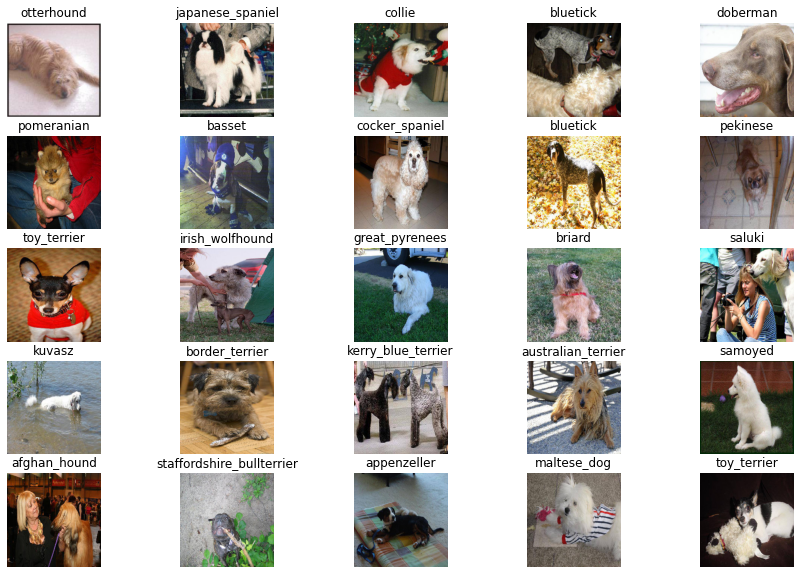

In [14]:
plot_images(x,y)

# **Building our Model**
---

### **Q.** What is meant by **Keras Applications** ?

**Ans:** 
* Keras Applications are deep learning models that are made available alongside pre-trained weights. 
* These models can be used for prediction, feature extraction, and fine-tuning.

( https://keras.io/api/applications/ )

### **Q.** What is **Transfer learning** ?

**Ans:** 
* A neural network is trained on a data. This network gains knowledge from this data, which is compiled as “weights” of the network. These weights can be extracted and then transferred to any other neural network. Instead of training the other neural network from scratch, we “**transfer**” the learned features.
* The approach involves the use of knowledge that was learned in some task, and apply it to solve the problem in the related target task.

### **Q.** What are **pre-trained models** ?

**Ans:** 
* In Machine Learning, a pre-trained model falls under the category of transfer learning. 
* Pre Trained models are machine learning models that are trained, developed and made available by other developers. 
* They are generally used to solve problems based on deep learning and are always trained on a very large dataset.
* They are made available by developers who want to contribute to the machine learning community to solve a similar problem.
* It contains the weights and biases that represent the features of whichever dataset it was trained on. Learned features are often transferable to different data. For example, a model trained on a large dataset of bird images will contain learned features like edges or horizontal lines that you would be transferable your dataset.

### **Q.** Why use Pre-trained model ?

**Ans:** 
* Pre-trained models are beneficial to us for many reasons. By using a pre-trained model you are saving time. Someone else has already spent the time and compute resources to learn a lot of features and your model will likely benefit from it.
* They are very well known for their high accuracies too.

### **Q.** What is **Inception-ResNet-v2** ?

**Ans:** 
* Inception-ResNet-v2 is a convolutional neural network that is trained on more than a million images from the ImageNet database.
* The network is 164 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. 
* As a result, the network has learned rich feature representations for a wide range of images. 
* The network has an image input size of 299-by-299.

( https://keras.io/api/applications/inceptionresnetv2/ )


---

# **InceptionResNetV2 Model**

In [15]:
# Loading the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

base_model.trainable=False
# The meaning of setting layer.trainable = False is to freeze the layer, i.e. its internal state will not change during training: 
# its trainable weights will not be updated during fit() or train_on_batch(), and its state updates will not be run.

219062272/219055592 [==============================] - 2s 0us/step


**Defining our model**
---

* **BatchNormalization**: 
  * It is a normalization technique which is done along mini-batches instead of the full data set. Its used  to speed up training and use higher learning rates.
  * It applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
* **GlobalAveragePooling2D**: 

  *  It takes a tensor of size (input width) x (input height) x (input channels) and computes the average value of all values across the entire (input width) x (input height) matrix for each of the (input channels).
  * It reduces the dimensionality of images by reducing the number of pixels in the output from the previous convolutional layer.
  * The output is a 1-dimensional tensor of size (input channels).

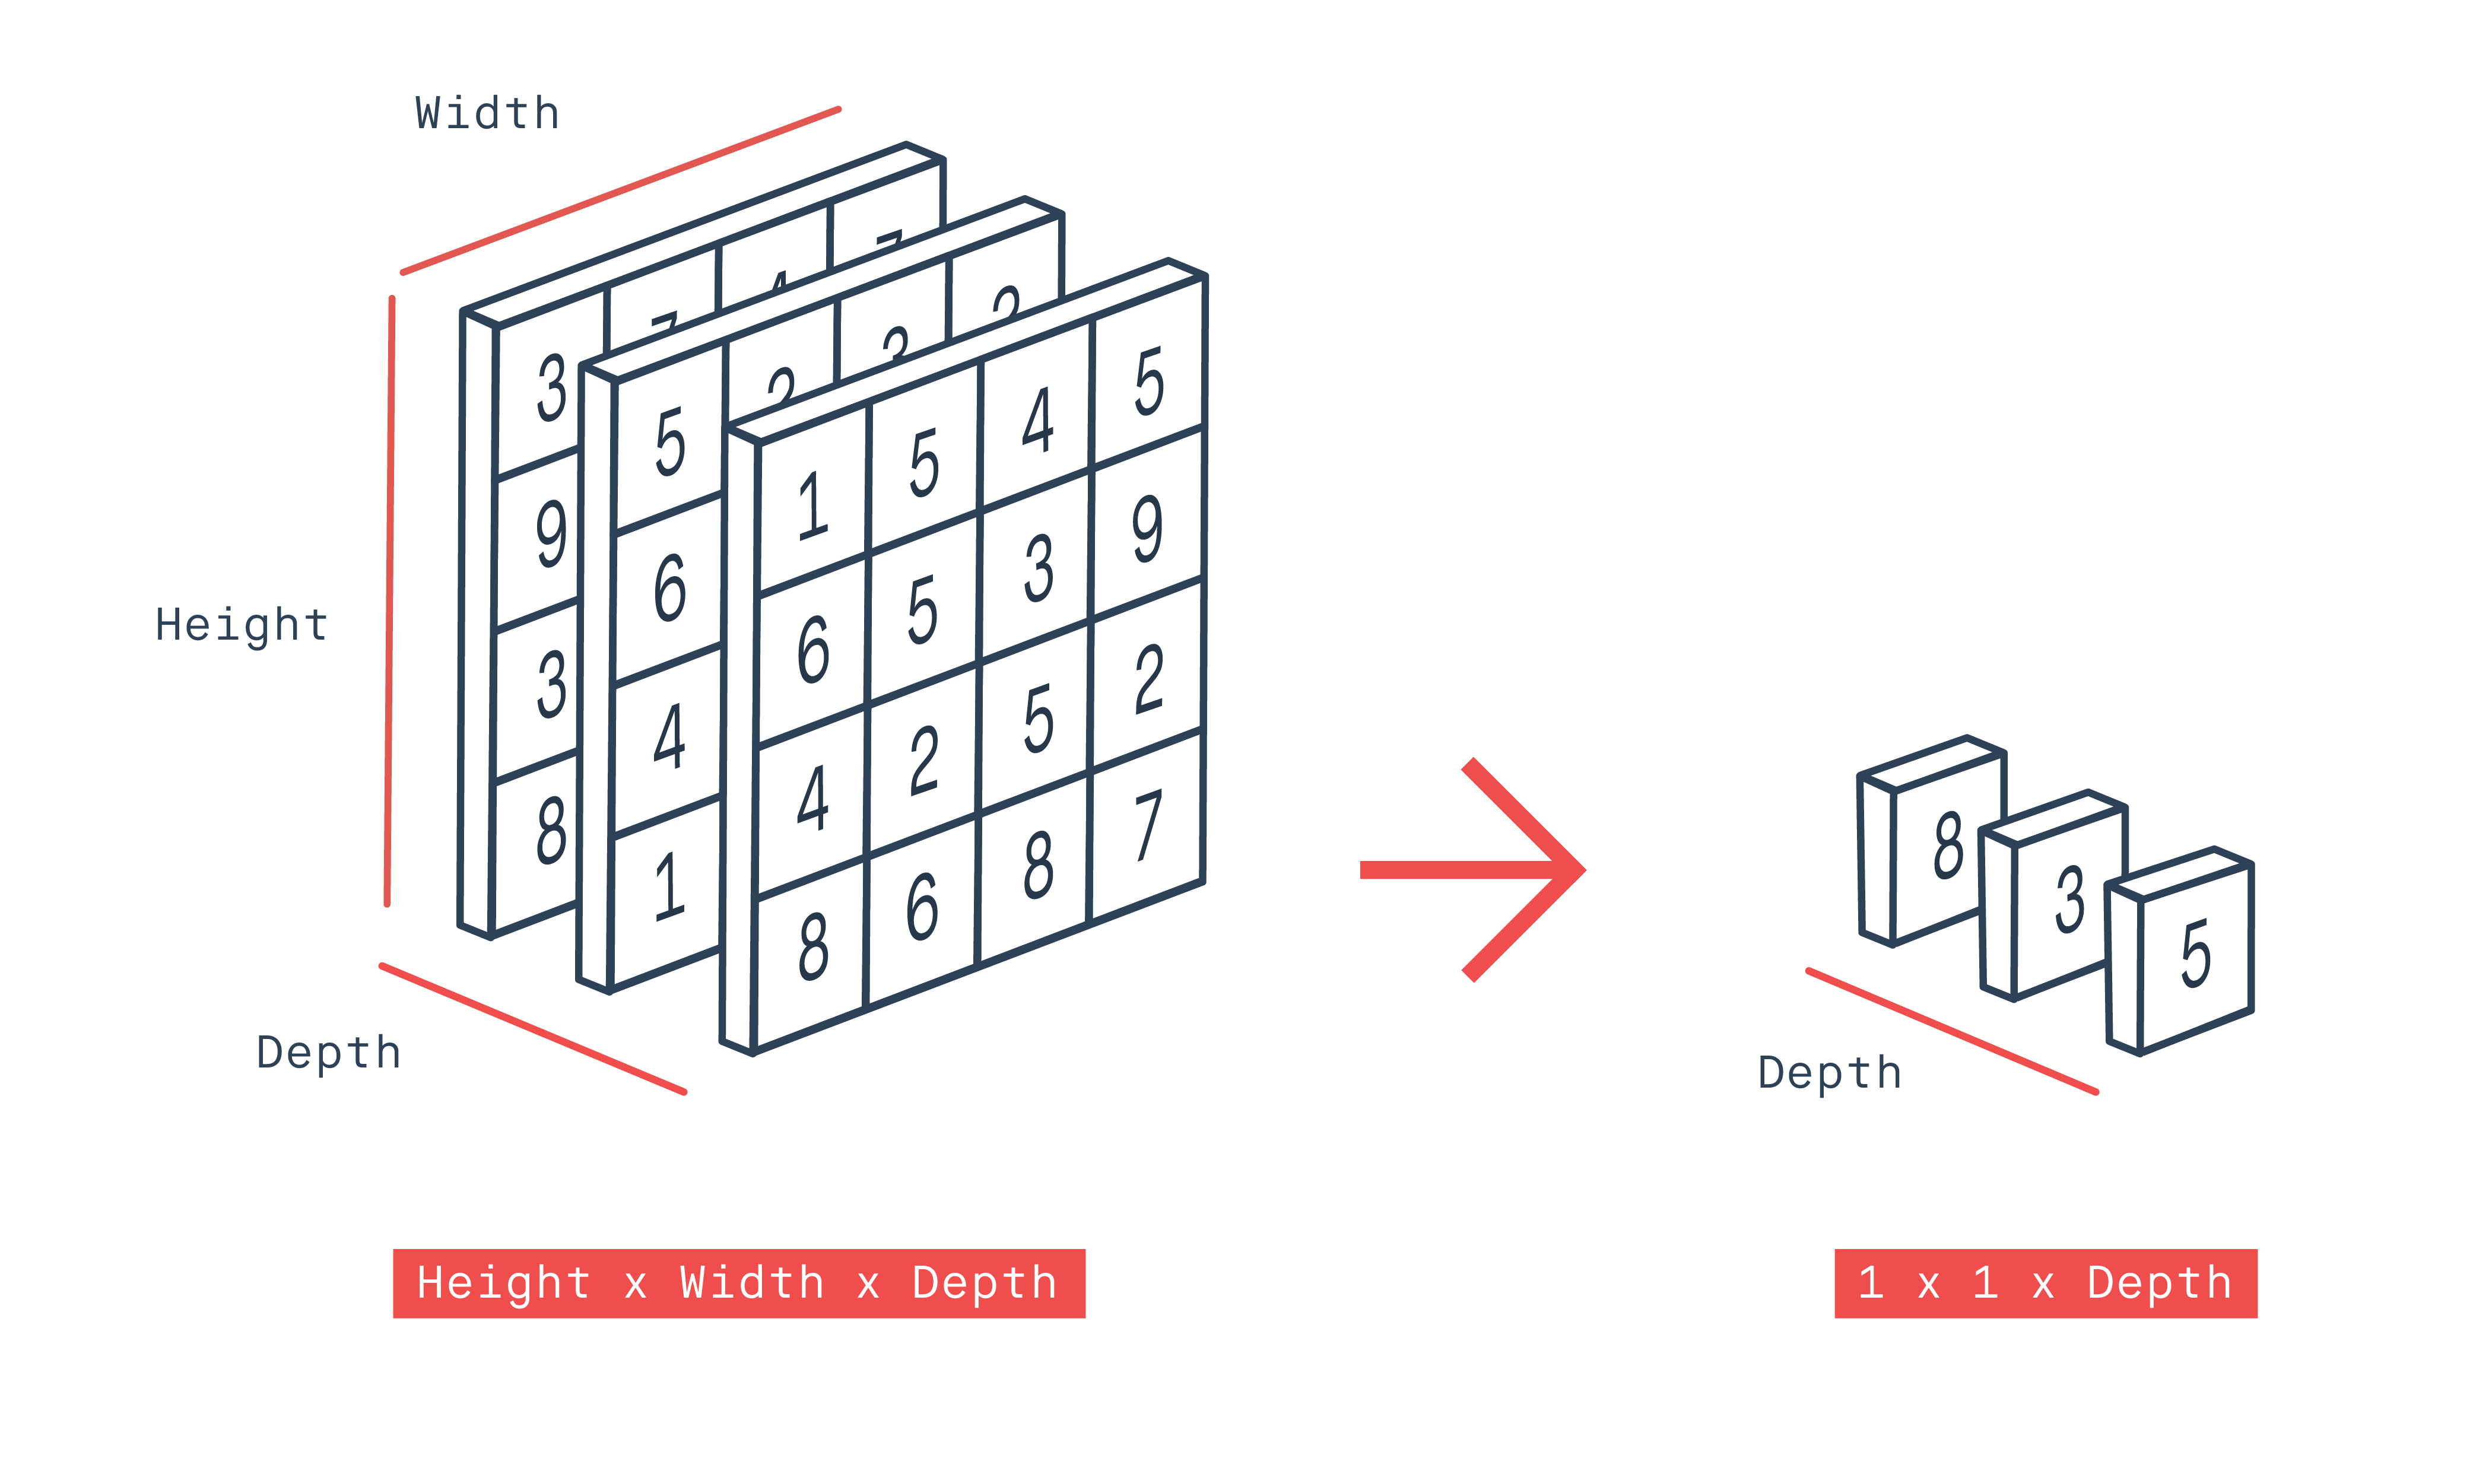

  2D Global average pooling operation. Here 'Depth' = 'Filters'

* **Dense** : This layer is a regular fully-connected NN layer. It is used without parameters.
* **Drop out layer** : is also used whose function is to randomly dropping some neurons from the input unit so as to prevent overfitting.
The value 0.5 indicates that 0.5 fraction of neurons has to be dropped.




In [16]:
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

# **Compile the model**

In [17]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for multi-class classification model where there are two or more output labels.
# using Adam optimizer

# **Displaying summary report of the model**

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 9, 9, 1536)        54336736  
_________________________________________________________________
batch_normalization_203 (Bat (None, 9, 9, 1536)        10752     
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

# **Visualization of the model architecture using plot_model api**

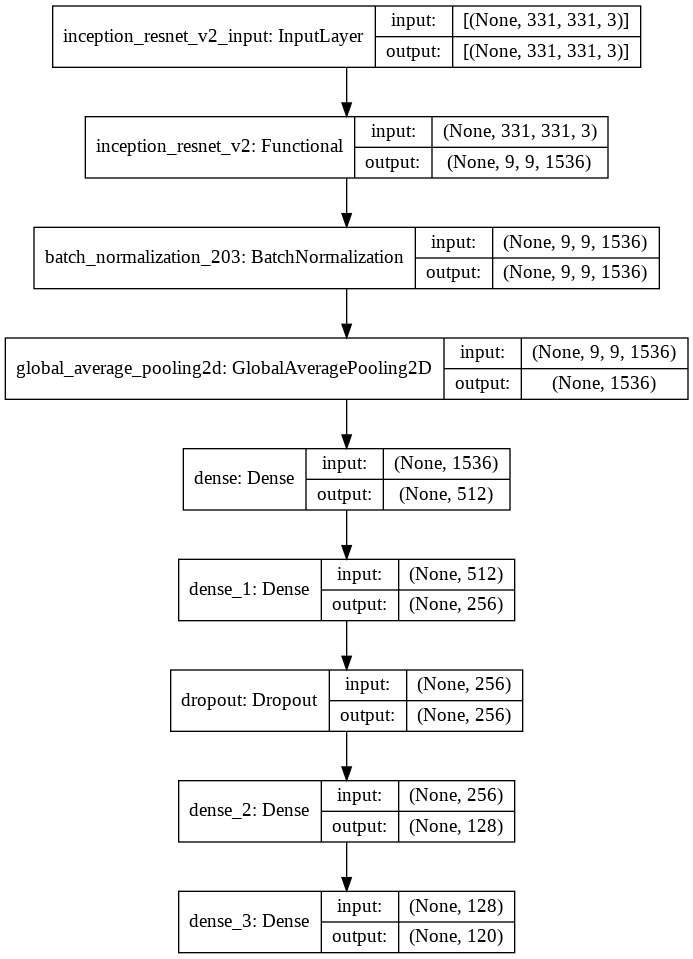

In [19]:
tf.keras.utils.plot_model(model,show_shapes=True)

# **Defining callbacks to preserve the best results**

**Q.** What is a Callback ?

**Ans.**  A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

( https://keras.io/api/callbacks/ )

In [20]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

# **Training the model**

In [21]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early]
                    )

Epoch 1/25
255/255 [==============================] - 3267s 13s/step - loss: 1.5007 - accuracy: 0.6806 - val_loss: 0.3956 - val_accuracy: 0.8938
Epoch 2/25
255/255 [==============================] - 122s 480ms/step - loss: 0.5099 - accuracy: 0.8729 - val_loss: 0.4213 - val_accuracy: 0.8948
Epoch 3/25
255/255 [==============================] - 127s 497ms/step - loss: 0.4416 - accuracy: 0.8826 - val_loss: 0.3888 - val_accuracy: 0.8978
Epoch 4/25
255/255 [==============================] - 127s 499ms/step - loss: 0.3915 - accuracy: 0.8945 - val_loss: 0.4146 - val_accuracy: 0.8958
Epoch 5/25
255/255 [==============================] - 127s 500ms/step - loss: 0.3432 - accuracy: 0.9057 - val_loss: 0.3889 - val_accuracy: 0.9008
Epoch 6/25
255/255 [==============================] - 126s 495ms/step - loss: 0.3053 - accuracy: 0.9141 - val_loss: 0.3808 - val_accuracy: 0.9112
Epoch 7/25
255/255 [==============================] - 126s 494ms/step - loss: 0.2923 - accuracy: 0.9152 - val_loss: 0.4112 - 

# **Save the model**

In [22]:
model.save("Model.h5") 

# **Visualizing The performance of the Model**

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9448809027671814\nValidation Accuracy: 0.9022817611694336')

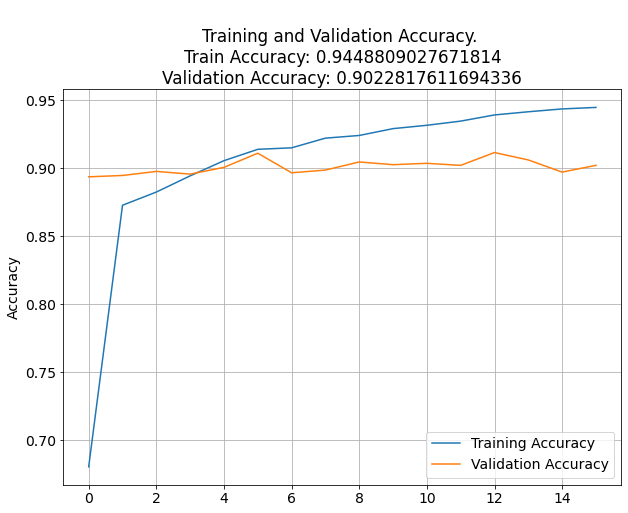

In [23]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

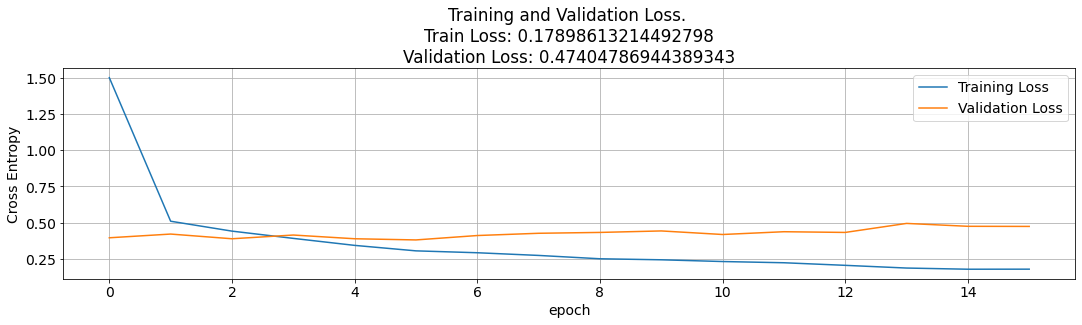

In [24]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

# **Evaluating the Accuracy of the model**

In [25]:
# Get the accuracy score of the model :)

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 

print("Loss: ",accuracy_score[0])

64/64 [==============================] - 27s 412ms/step - loss: 0.3845 - accuracy: 0.9110
[0.38452133536338806, 0.9109588861465454]
Accuracy: 91.0959%
Loss:  0.38452133536338806


# **Making Predictions on the test data**

### Viewing the Test Image

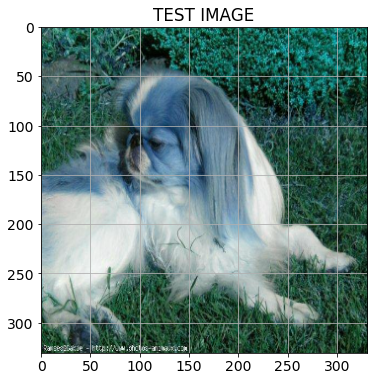

In [30]:
test_img_path = test_path+"/000621fb3cbb32d8935728e48679680e.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [33]:
predictions = []

for image in sample.id:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': sample.id, 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)

In [34]:
# Submission file ouput
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output

Submission File: 
---------------

                               image_id  label
0  000621fb3cbb32d8935728e48679680e.jpg     61
1  00102ee9d8eb90812350685311fe5890.jpg     94
2  0012a730dfa437f5f3613fb75efcd4ce.jpg     40
3  001510bc8570bbeee98c8d80c8a95ec1.jpg     88
4  001a5f3114548acdefa3d4da05474c2e.jpg     70
